# Исследование продаж  игр для интернет-магазина «Стримчик»

## Цель проекта
Определить закономерности, влияющие на успешность игр. Это поможет интернет-магазину сделать ставку на потенциально популярные продукты и спланировать рекламные кампании на 2017 год.

## Задачи проекта
1. Изучить общую информацию о данных.
2. Подготовить данные к анализу:
   - Привести названия столбцов к нижнему регистру;
   - Преобразовать типы данных;
   - Обработать пропуски;
   - Обработать значения `'tbd'` в оценках пользователей;
   - Посчитать суммарные продажи.
3. Провести исследовательский анализ:
   - Изучить выпуск игр по годам;
   - Выявить динамику продаж по платформам;
   - Исследовать влияние отзывов на продажи;
   - Определить прибыльные жанры.
4. Составить портрет пользователей по регионам (NA, EU, JP):
   - Популярные платформы;
   - Популярные жанры;
   - Влияние рейтинга ESRB.
5. Проверить гипотезы:
   - Средние пользовательские рейтинги Xbox One и PC одинаковы;
   - Средние пользовательские рейтинги жанров Action и Sports различаются.
6. Сделать общий вывод.

## Исходные данные
В датасете содержится информация о продажах игр до 2016 года, включая оценки критиков и пользователей, жанры, платформы и рейтинг ESRB.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

# Шаг 1. Изучение общей информации о данных

In [2]:
data = pd.read_csv('./games.csv')
data.head(10)

,Name,Platform,Year_of_Release,Genre,NA_sales,EU_sales,JP_sales,Other_sales,Critic_Score,User_Score,Rating
0,Wii Sports,Wii,2006.0,Sports,41.36,28.96,3.77,8.45,76.0,8,E
1,Super Mario Bros.,NES,1985.0,Platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN
2,Mario Kart Wii,Wii,2008.0,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E
3,Wii Sports Resort,Wii,2009.0,Sports,15.61,10.93,3.28,2.95,80.0,8,E
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,NaN
5,Tetris,GB,1989.0,Puzzle,23.20,2.26,4.22,0.58,NaN,NaN,NaN
6,New Super Mario Bros.,DS,2006.0,Platform,11.28,9.14,6.50,2.88,89.0,8.5,E
7,Wii Play,Wii,2006.0,Misc,13.96,9.18,2.93,2.84,58.0,6.6,E
8,New Super Mario Bros. Wii,Wii,2009.0,Platform,14.44,6.94,4.70,2.24,87.0,8.4,E
9,Duck Hunt,NES,1984.0,Shooter,26.93,0.63,0.28,0.47,NaN,NaN,NaN


In [3]:
data.shape

(16715, 11)

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Name             16713 non-null  object 
 1   Platform         16715 non-null  object 
 2   Year_of_Release  16446 non-null  float64
 3   Genre            16713 non-null  object 
 4   NA_sales         16715 non-null  float64
 5   EU_sales         16715 non-null  float64
 6   JP_sales         16715 non-null  float64
 7   Other_sales      16715 non-null  float64
 8   Critic_Score     8137 non-null   float64
 9   User_Score       10014 non-null  object 
 10  Rating           9949 non-null   object 
dtypes: float64(6), object(5)
memory usage: 1.4+ MB


In [5]:
# Количество пропусков в проценах
pd.DataFrame(round(data.isna().mean()*100,1)).style.background_gradient('coolwarm')

,0
Name,0.000000
Platform,0.000000
Year_of_Release,1.600000
Genre,0.000000
NA_sales,0.000000
EU_sales,0.000000
JP_sales,0.000000
Other_sales,0.000000
Critic_Score,51.300000
User_Score,40.100000


###### Общая информация о таблице

- В таблице 16 715 строк и 11 столбцов.
- Названия столбцов не соответствуют общепринятому стилю — их нужно привести к нижнему регистру (snake_case).
- Есть ошибки в типах данных (например, `Year_of_Release` — float, а должен быть int; `User_Score` — object вместо float).
- Обнаружены пропуски, особенно в столбце `Critic_Score` (пропущено около половины значений).
- В столбце `User_Score` встречается значение `'tbd'`, его нужно будет обработать отдельно.

# Шаг 2. Предобработка данных

In [6]:
data.columns = data.columns.str.lower()

Вместо привычного `rename` использовали `str.lower()` так как именно ошибок в названиях столбцов нету они их просто нужно было привести к нижему регистру

In [7]:
data.duplicated().sum()

np.int64(0)

In [8]:
data[data[['name', 'platform','year_of_release']].duplicated(keep=False)]

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
604,Madden NFL 13,PS3,2012.0,Sports,2.11,0.22,0.00,0.23,83.0,5.5,E
659,NaN,GEN,1993.0,NaN,1.78,0.53,0.00,0.08,NaN,NaN,NaN
14244,NaN,GEN,1993.0,NaN,0.00,0.00,0.03,0.00,NaN,NaN,NaN
16230,Madden NFL 13,PS3,2012.0,Sports,0.00,0.01,0.00,0.00,83.0,5.5,E


Мы нашли неявные дубликаты — строки с одинаковыми значениями `name`, `platform` и `year_of_release`, но различающимися значениями по продажам. Такие дубликаты могут появляться из-за ошибок при логировании или сбора данных из разных источников.

Чтобы избежать искажения статистики, мы объединили дубликаты, сгруппировав их и просуммировав числовые значения по продажам.


In [9]:
data['total_sales'] = data[['na_sales', 'eu_sales', 'jp_sales', 'other_sales']].sum(axis=1)

# Удалим дубликаты, сложив продажи
data = data.groupby(['name', 'platform', 'year_of_release', 'genre', 'rating', 'critic_score', 'user_score'], as_index=False).agg({
    'na_sales': 'sum',
    'eu_sales': 'sum',
    'jp_sales': 'sum',
    'other_sales': 'sum',
    'total_sales': 'sum'
})

In [10]:
data['user_score'].unique()

array(['7.9', '8.5', '8.9', '8.7', '4.6', 'tbd', '6.3', '6.6', '7.5',
       '7.1', '6.7', '3.2', '8.3', '6.8', '5.7', '6.9', '7.7', '5.6', '9',
       '7.8', '7.4', '8.1', '4.3', '4.4', '8.2', '4.9', '7.2', '8', '6.2',
       '6.4', '5.9', '5.2', '5.3', '4.2', '8.4', '9.1', '9.4', '6.5',
       '5.8', '3', '7', '6.1', '7.3', '5.5', '6', '3.5', '3.6', '3.8',
       '7.6', '9.2', '5.4', '4.8', '4.5', '8.8', '2', '3.7', '2.5', '5',
       '2.7', '3.1', '8.6', '4', '4.1', '1.7', '4.7', '3.4', '2.8', '5.1',
       '2.1', '1.5', '9.6', '2.2', '2.4', '1.8', '2.6', '3.3', '0.5',
       '1.9', '9.3', '0.9', '3.9', '1', '2.9', '2.3', '9.5', '1.2', '0.7',
       '1.3', '1.4', '0.6'], dtype=object)

In [11]:
data['user_score'] = data['user_score'].replace('tbd', 0)

В столбце user_score встречается значение "tbd" — это сокращение от "To Be Determined", то есть "будет определено позже". Такие значения означают, что оценка от пользователей ещё не выставлена, и это не числовое значение.

Чтобы можно было работать со столбцом как с числовым (например, вычислять среднее значение, строить графики, делать фильтрации и т.д.), мы заменяем "tbd" на NaN — специальное значение, обозначающее пропущенные данные.

In [12]:
data['year_of_release'] = data['year_of_release'].astype('Int64')
data['user_score'] = data['user_score'].astype('float')

- `year_of_release` заменили именно на `int64` , а не привичный `datetime` так как тут нету месяцев стоит только год
- `user_score` заменили на float так как это числовые значения 

In [13]:
data = data.dropna(subset=['name', 'genre', 'year_of_release'])

- Удалили строки с пропущенными значениями в столбцах `name`, `genre` и `year_of_release`, так как количество таких строк незначительно, и без этих данных анализ невозможен.
- Столбцы `user_score`, `critic_score` и `rating` содержат большое количество пропусков, поэтому их не заполняли.
  - Заполнение средним или медианным значением в данном случае нецелесообразно, так как оценки пользователей и критиков, а также рейтинг ESRB могут быть уникальны для каждой конкретной игры.


In [14]:
# Столбец с суммарными продажами
data['total_sales'] = (
    data['na_sales'] + data['eu_sales'] + data['jp_sales'] + data['other_sales']
)

Для удобства анализа мы рассчитали новый столбец total_sales, который отражает суммарные продажи каждой игры во всех регионах: Северной Америке, Европе, Японии и других странах.

In [15]:
data['rating'] = data['rating'].fillna('Unknown')

Пропуски в рейтинге заменили на 'Unknown', чтобы не терять игры без рейтинга. Часто такие игры продаются вне США и Канады, где ESRB не применяется. Это нужно, чтобы учитывать все данные в анализе.

# Шаг 3. Исследовательский анализ данных 

In [16]:
data['year_of_release'].value_counts().sort_index(ascending=False)

year_of_release
2016    217
2015    212
2014    257
2013    267
2012    312
2011    486
2010    496
2009    644
2008    708
2007    692
2006    617
2005    652
2004    556
2003    582
2002    627
2001    325
2000    141
1999     36
1998     25
1997     14
1996      7
1994      1
1992      1
1988      1
1985      1
Name: count, dtype: Int64

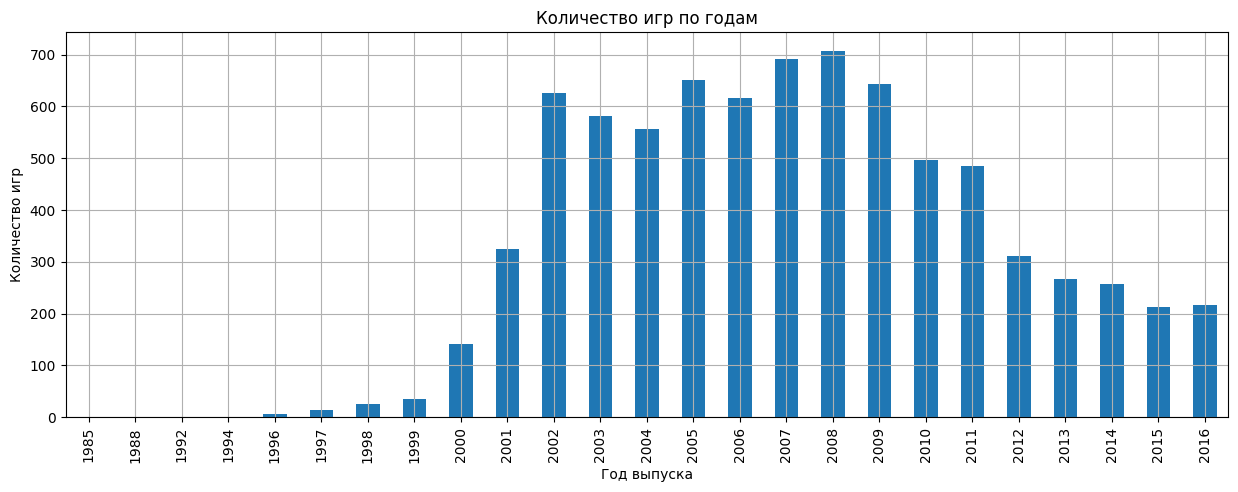

In [17]:
data['year_of_release'].value_counts().sort_index().plot(kind='bar', figsize=(15, 5))
plt.title('Количество игр по годам')
plt.xlabel('Год выпуска')
plt.ylabel('Количество игр')
plt.grid(True)
plt.show()

###### Количество выпускаемых игр по годам

- До 1994 года — количество выпускаемых игр крайне низкое, менее 100 игр в год.

- 1995–2000 годы — наблюдается постепенный рост: количество игр увеличивается от ~200 и выше.

- С 2001 года начинается устойчивый рост — количество выпускаемых игр превышает 700 в год, и эта тенденция продолжается до 2008 года.

- Пик в 2008–2009 годах — самый продуктивный период: выпускается более 1400 игр в год.

- После 2011 года — заметный спад: количество игр снижается до уровня менее 600 в год.


Актуальный период для анализа: с 2001 года по 2016 год
(данные до 2000 года лучше исключить из анализа, они нерепрезентативны для прогноза на 2017 год).

In [18]:
actual_data = data.query('year_of_release >= 2001')

In [19]:
actual_data.groupby('platform')['total_sales'].sum().sort_values(ascending=False)

platform
PS2     947.77
X360    858.66
PS3     788.92
Wii     682.11
DS      433.97
PS4     243.05
XB      225.67
PSP     196.55
PC      176.55
GC      169.37
GBA     165.66
XOne    129.62
3DS     124.13
WiiU     66.27
PSV      30.94
PS       19.69
DC        0.53
Name: total_sales, dtype: float64

- Выберем топ 5 платформ и построим по ним график

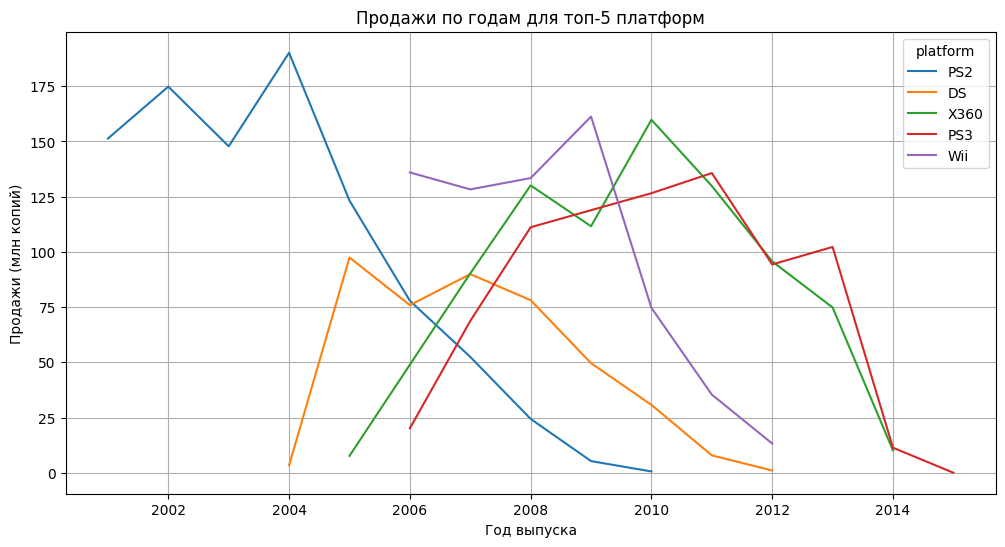

In [20]:
top_platforms = ['PS2', 'X360', 'PS3', 'Wii', 'DS']
platform_data = actual_data.query('platform in @top_platforms')


sales_by_year = (
    platform_data
    .groupby(['year_of_release', 'platform'])['total_sales']
    .sum()
    .reset_index()
)

plt.figure(figsize=(12, 6))
sns.lineplot(data=sales_by_year, x='year_of_release', y='total_sales', hue='platform')
plt.title('Продажи по годам для топ-5 платформ')
plt.xlabel('Год выпуска')
plt.ylabel('Продажи (млн копий)')
plt.grid(True)
plt.show()

###### PS2
- Старт 2001
- Пик с 2002 до 2004
- Продажи падали с 2005
- Полностью ушла с рынка к 2011

###### DS
- Старт 2004
- Пик с 2007 до 2008
- Продажи падали с 2009
- Полностью ушла с рынка к 2013

###### X360
- Старт 2005
- Пик в 2010
- Продажи падали с 2011
- Полностью ушла с рынка к 2016

###### PS3
- Старт 2006
- Пик с 2008 до 2011
- Продажи падали с 2012
- Полностью ушла с рынка к 2016

###### Wii
- Старт 2006
- Пик в 2009
- Продажи падали с 2010
- Полностью ушла с рынка к 2016

мне кажется нужно взять выборку начиная с 2010 года так как тут уже все старые модели уже почти на нуле и в тренде более новые модели по типу ps3 x360

###### Общий вывод:

- Жизненный цикл платформы (от старта до выхода с рынка) в среднем составляет 10–12 лет.

- Пиковый период продаж приходится примерно на 3–5 лет после запуска, затем наблюдается спад.

In [21]:
actual_data = data.query('year_of_release >= 2012 and year_of_release <= 2016')

In [22]:
actual_data.groupby('platform')['total_sales'].sum().sort_values(ascending=False)

platform
PS4     243.05
PS3     207.88
X360    180.60
XOne    129.62
3DS      79.71
WiiU     66.27
PC       54.31
PSV      27.06
Wii      13.23
DS        1.02
PSP       0.15
Name: total_sales, dtype: float64

- Снова выберем топ 5 платформ и построим по ним ящик с усами

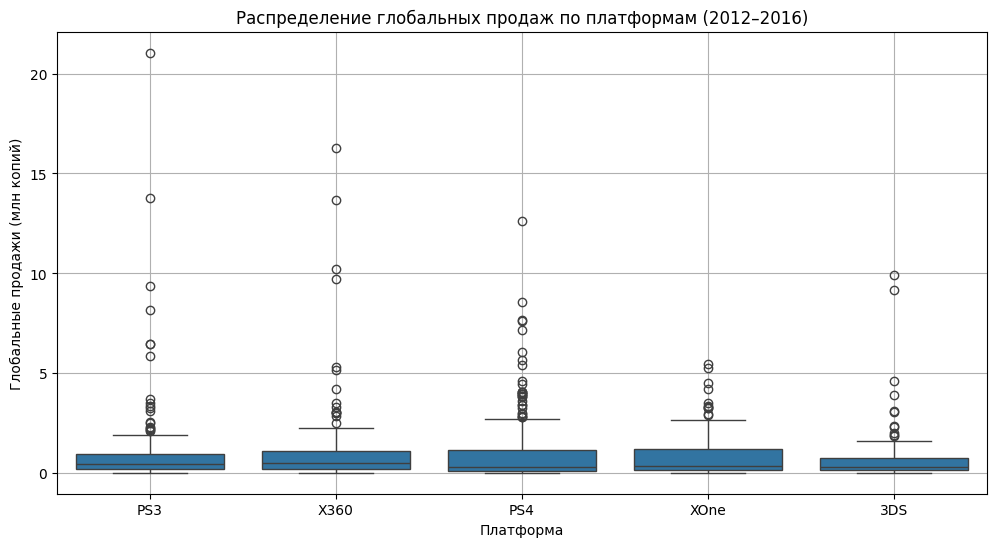

In [23]:
top_platforms = ['PS4', 'PS3', 'X360', 'XOne', '3DS']
top_data = actual_data.query('platform in @top_platforms')

plt.figure(figsize=(12, 6))
sns.boxplot(data=top_data, x='platform', y='total_sales')
plt.title('Распределение глобальных продаж по платформам (2012–2016)')
plt.xlabel('Платформа')
plt.ylabel('Глобальные продажи (млн копий)')
plt.grid(True)
plt.show()

- У всех платформ медиана продаж находится примерно ниже 1 млн копий.
- У PS4 и XOne медиана чуть выше, чем у остальных.
- У всех платформ заметно большое количество выбросов — игры, которые продавались значительно лучше других (до 22 млн копий).
- Это говорит о том, что некоторые хиты значительно превосходили остальные по продажам.
- У платформ X360, X360 и PS4 IQR шире → более разнообразные продажи.
- У PS3 и 3DS коробка меньше → продажи более сконцентрированы в узком диапазоне.

###### Выводы:
- У всех платформ основная масса игр продавалась в пределах до 1-2 млн копий, но есть значительное число хитов.
- Платформы XOne и PS4 выделяются как более успешные с точки зрения "топ-продаж".
- Много выбросов — индустрия видеоигр сильно зависит от хитов.

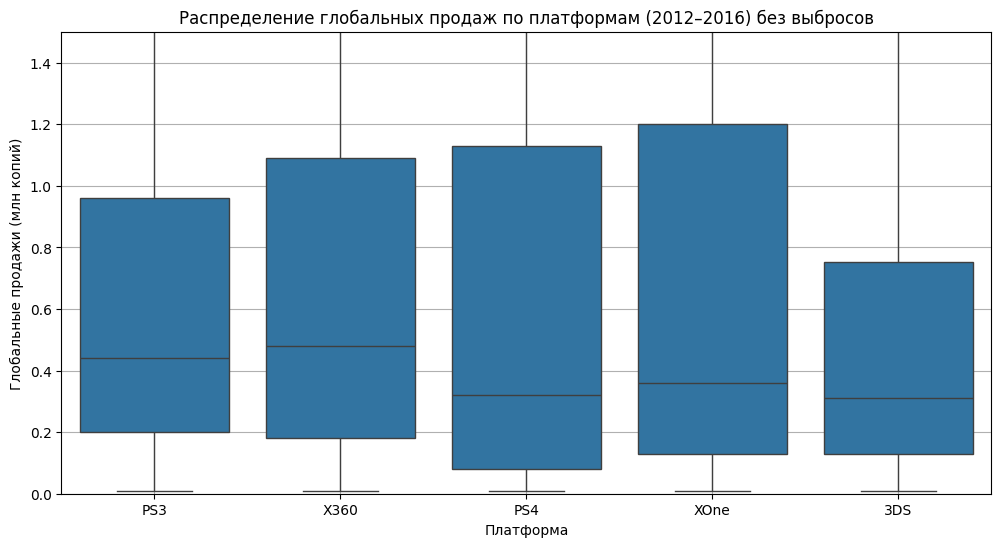

In [24]:
top_platforms = ['PS4', 'PS3', 'X360', 'XOne', '3DS']
top_data = actual_data.query('platform in @top_platforms')

plt.figure(figsize=(12, 6))
sns.boxplot(data=top_data, x='platform', y='total_sales')
plt.ylim(0, 1.5)  
plt.title('Распределение глобальных продаж по платформам (2012–2016) без выбросов')
plt.xlabel('Платформа')
plt.ylabel('Глобальные продажи (млн копий)')
plt.grid(True)
plt.show()

Распределение глобальных продаж по платформам (2010–2016), без выбросов:

- Медиана продаж у всех платформ находится в пределах 0.3–0.5 млн копий. Самая высокая медиана — у X360 и XOne (0.45 млн), самая низкая — у 3DS (~0.3 млн).

- Наибольший межквартильный размах (IQR) у платформ XOne, PS4 и X360, что говорит о широком разбросе типичных продаж — от малотиражных до среднеуспешных игр.

- Наименьший IQR у 3DS, что указывает на более сосредоточенные продажи — большинство игр продавались в похожем диапазоне.

- Несмотря на отсутствие выбросов на этом графике, по предыдущей версии мы знаем, что у всех платформ встречаются отдельные хиты, значительно превышающие типичные значения (в 5–10 раз и выше).

- Теперь проверим влияют ли отзывы критиков и пользователей на продажи игр, выберем топ 5 платформ и посчитаем кореляцию 
- `user_score` vs `total_sales`

- `critic_score` vs `total_sales`


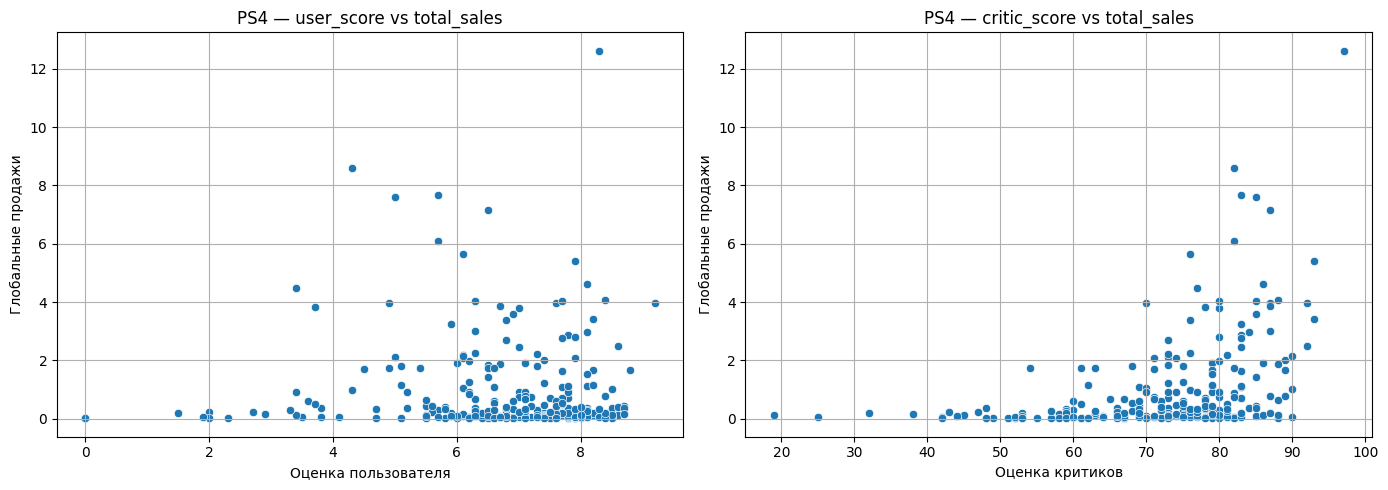

▶ Платформа: PS4
  Корреляция (user_score и total_sales): -0.01
  Корреляция (critic_score и total_sales): 0.40
--------------------------------------------------


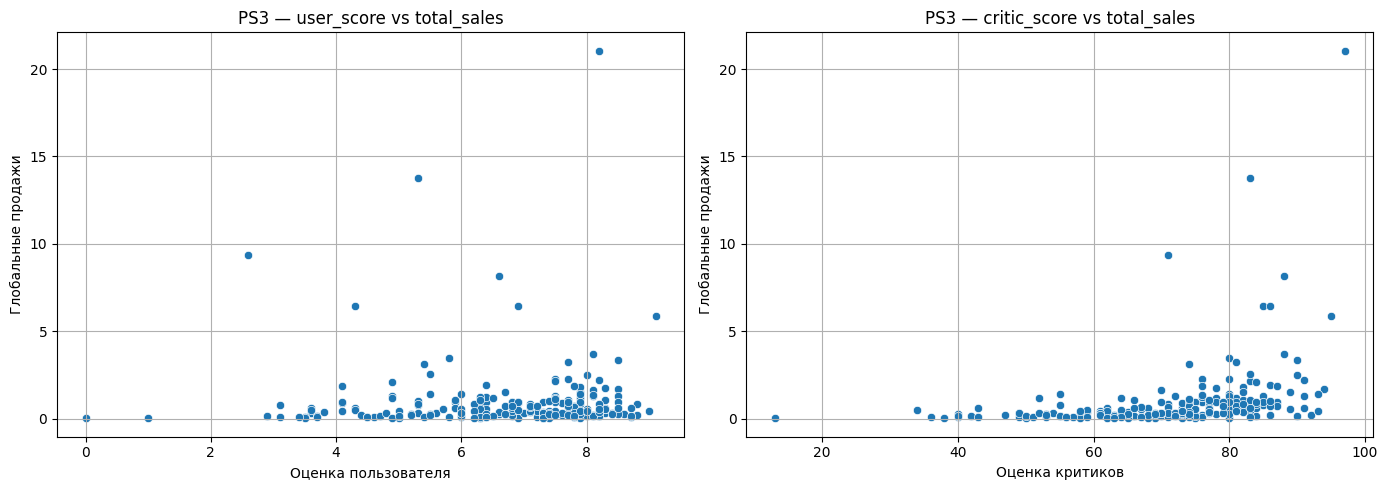

▶ Платформа: PS3
  Корреляция (user_score и total_sales): 0.01
  Корреляция (critic_score и total_sales): 0.33
--------------------------------------------------


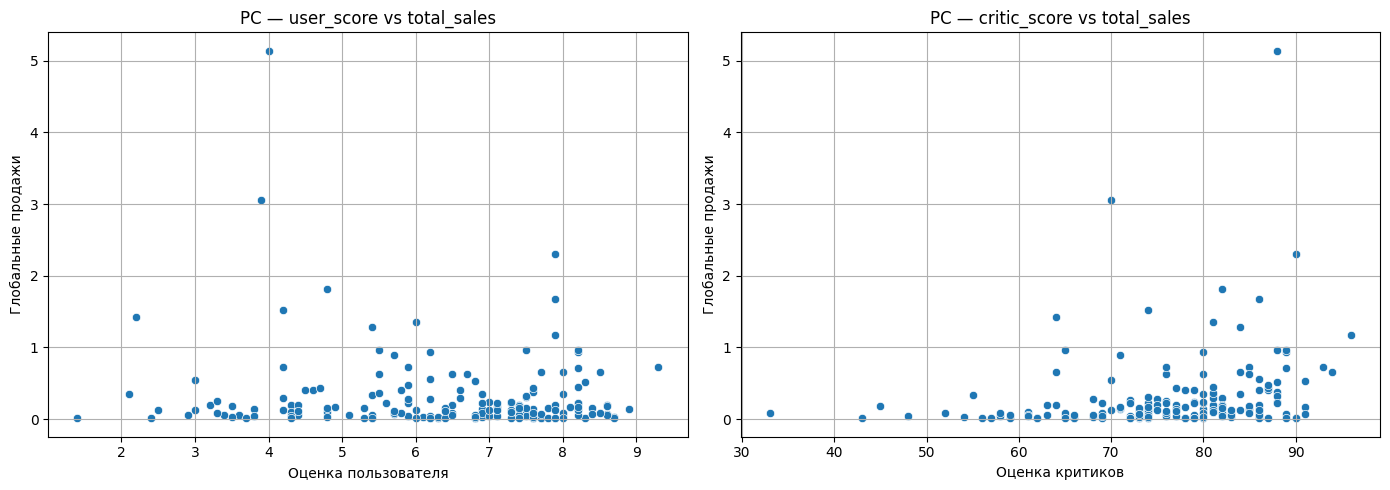

▶ Платформа: PC
  Корреляция (user_score и total_sales): -0.12
  Корреляция (critic_score и total_sales): 0.22
--------------------------------------------------


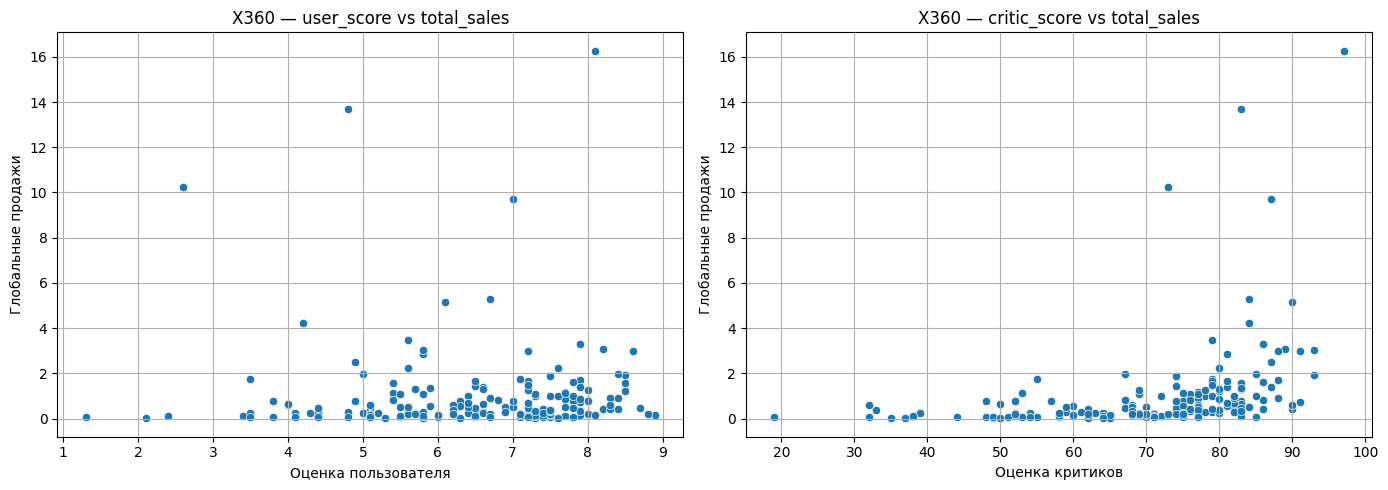

▶ Платформа: X360
  Корреляция (user_score и total_sales): 0.00
  Корреляция (critic_score и total_sales): 0.36
--------------------------------------------------


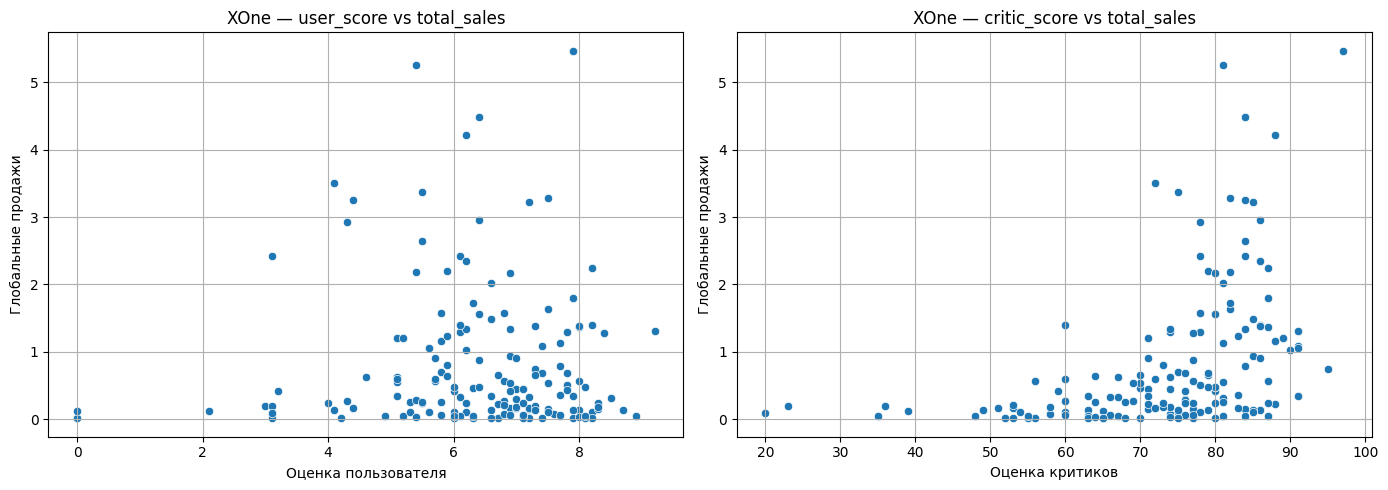

▶ Платформа: XOne
  Корреляция (user_score и total_sales): -0.03
  Корреляция (critic_score и total_sales): 0.41
--------------------------------------------------


In [25]:
# Выбираем топ-5 платформ по числу игр
top_platforms = actual_data['platform'].value_counts().head(5).index


# Строим графики и считаем корреляции
for platform in top_platforms:
    platform_data = actual_data[actual_data['platform'] == platform]

    plt.figure(figsize=(14, 5))

    # Диаграмма рассеяния для user_score
    plt.subplot(1, 2, 1)
    sns.scatterplot(data=platform_data, x='user_score', y='total_sales')
    plt.title(f'{platform} — user_score vs total_sales')
    plt.xlabel('Оценка пользователя')
    plt.ylabel('Глобальные продажи')
    plt.grid(True)

    # Диаграмма рассеяния для critic_score
    plt.subplot(1, 2, 2)
    sns.scatterplot(data=platform_data, x='critic_score', y='total_sales')
    plt.title(f'{platform} — critic_score vs total_sales')
    plt.xlabel('Оценка критиков')
    plt.ylabel('Глобальные продажи')
    plt.grid(True)

    plt.tight_layout()
    plt.show()

    # Вывод корреляций
    user_corr = platform_data['user_score'].corr(platform_data['total_sales'])
    critic_corr = platform_data['critic_score'].corr(platform_data['total_sales'])

    print(f'▶ Платформа: {platform}')
    print(f'  Корреляция (user_score и total_sales): {user_corr:.2f}')
    print(f'  Корреляция (critic_score и total_sales): {critic_corr:.2f}')
    print('-' * 50)

###### Влияние отзывов на продажи топ 5 платформ


- оценки критиков **слабо, но влияют** на продажи;
- пользовательские оценки **почти не связаны** с продажами;
- возможно, игроки покупают игры ещё до формирования пользовательских отзывов.


- Посмотрим распределение игр по жанрам


In [26]:
actual_data['genre'].value_counts()

genre
Action          425
Shooter         171
Role-Playing    159
Sports          136
Racing           79
Fighting         63
Platform         59
Misc             56
Adventure        48
Simulation       35
Strategy         25
Puzzle            9
Name: count, dtype: int64

- **Action** — уверенный лидер по числу игр. Это, скорее всего, связано с популярностью и широким охватом игроков.

- **Misc**, **Sports**, **Role-Playing**, **Adventure** — тоже распространены.

- **Puzzle**, **Platform**, **Strategy** — самые редкие.

In [27]:
actual_data.groupby('genre')['total_sales'].sum().sort_values(ascending=False)

genre
Action          328.26
Shooter         241.37
Sports          138.76
Role-Playing     91.29
Platform         49.58
Racing           41.56
Misc             37.75
Fighting         26.21
Simulation       24.39
Adventure        11.30
Strategy          9.29
Puzzle            3.14
Name: total_sales, dtype: float64

- **Action** — и самый массовый, и самый прибыльный жанр.

- **Shooter** — хотя меньше по количеству игр, но почти догоняет по прибыли Action.

- **Puzzle** и **Strategy** — имеют наименьшие продажи и наименьшее количество игр.

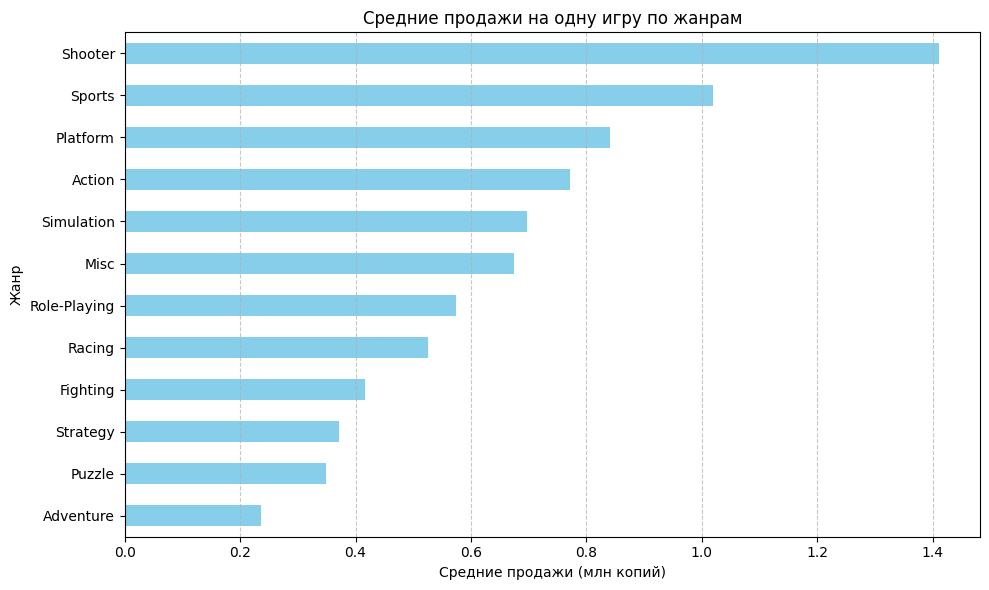

In [28]:
# Средние продажи на одну игру в каждом жанре
genre_avg_sales = actual_data.groupby('genre')['total_sales'].mean().sort_values(ascending=False)
genre_avg_sales.plot(kind='barh', figsize=(10,6), color='skyblue')
plt.title('Средние продажи на одну игру по жанрам')
plt.xlabel('Средние продажи (млн копий)')
plt.ylabel('Жанр')
plt.gca().invert_yaxis()  
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

- Тут уже другая картина видно как сильно **Shooter** и **Platform** отделяются по продажам на одну игру в каждом жанре)

# Шаг 4. Портрет пользователя каждого региона

In [29]:
regions = ['na_sales', 'eu_sales', 'jp_sales']

In [30]:
for region in regions:
    print(f"\nТоп платформ в {region.upper()} (в долях):")
    platform_sales = actual_data.groupby('platform')[region].sum()
    top5 = platform_sales.sort_values(ascending=False).head(5)
    shares = top5 / top5.sum() * 100
    display(shares.round(2).to_frame(name='Доля (%)'))


Топ платформ в NA_SALES (в долях):


,Доля (%)
platform,
X360,28.53
PS4,22.49
PS3,20.56
XOne,20.20
WiiU,8.22



Топ платформ в EU_SALES (в долях):


,Доля (%)
platform,
PS4,34.86
PS3,24.42
X360,17.77
XOne,13.12
PC,9.83



Топ платформ в JP_SALES (в долях):


,Доля (%)
platform,
3DS,36.24
PS3,27.64
WiiU,13.86
PS4,12.66
PSV,9.60


###### Популяность платформ по регионам:

- Северная Америка (NA):

  - Лидирует X360 (28.53%), далее PS4 (22.49%), PS3 (20.56%) и XOne (20.20%).

  - Рынок ориентирован на домашние консоли, особенно популярны платформы с фокусом на экшн и шутеры.

- Европа (EU):

    - Ведущая платформа — PS4 (34.86%), далее PS3 (24.42%) и X360 (17.77%).

    - Европейский рынок также предпочитает домашние консоли, но заметно больше интереса к ПК — PC занимает 9.83% (в отличие от других регионов).

- Япония (JP):

    - Абсолютный лидер — 3DS (36.24%), также популярны PS3 (27.64%) и WiiU (13.86%).

    - Японский рынок ориентирован на портативный гейминг, что отражает локальные особенности потребления (мобильность, компактность).



In [31]:
for region in regions:
    print(f"\nТоп жанров в {region.upper()} (в долях):")
    genre_sales = actual_data.groupby('genre')[region].sum()
    top5 = genre_sales.sort_values(ascending=False).head(5)
    shares = top5 / top5.sum() * 100
    display(shares.round(2).to_frame(name='Доля (%)'))


Топ жанров в NA_SALES (в долях):


,Доля (%)
genre,
Action,36.86
Shooter,30.63
Sports,17.43
Role-Playing,9.66
Platform,5.42



Топ жанров в EU_SALES (в долях):


,Доля (%)
genre,
Action,39.97
Shooter,28.01
Sports,16.59
Role-Playing,8.88
Racing,6.55



Топ жанров в JP_SALES (в долях):


,Доля (%)
genre,
Action,34.07
Role-Playing,28.50
Platform,12.99
Shooter,12.44
Simulation,12.00


###### Популярность жанров по регионам:

- NA и EU: доминирует жанр Action (NA — 36.86%, EU — 39.97%), следом идут Shooter и Sports.

- JP: заметное лидерство у RPG (28.50%), но Action тоже популярен (34.07%), далее — Platform, Shooter и Simulation.

Вывод:

- Западные рынки (NA и EU) отдают предпочтение активным и соревновательным жанрам — экшен, стрелялки, спорт.

- Японский рынок тяготеет к сюжетным и атмосферным играм (RPG), но экшен здесь тоже очень популярен. Это отражает вкусы игроков и успех культовых серий вроде Final Fantasy, Dragon Quest и Monster Hunter.

In [32]:
for region in regions:
    print(f"\nДоли продаж по рейтингу ESRB в {region.upper()}:")
    rating_sales = actual_data.groupby('rating')[region].sum().sort_values(ascending=False)
    rating_shares = rating_sales / rating_sales.sum() * 100
    display(rating_shares.round(2).to_frame(name='Доля (%)'))


Доли продаж по рейтингу ESRB в NA_SALES:


,Доля (%)
rating,
M,49.84
E,22.72
T,14.04
E10+,13.41



Доли продаж по рейтингу ESRB в EU_SALES:


,Доля (%)
rating,
M,49.29
E,26.17
T,13.37
E10+,11.17



Доли продаж по рейтингу ESRB в JP_SALES:


,Доля (%)
rating,
E,34.94
T,28.51
M,26.11
E10+,10.45


###### Влияние рейтинга ESRB на продажи:


- В регионах NA и EU наибольшие доли продаж приходятся на игры с рейтингом M (Mature):

    - NA — 49.84%,

    - EU — 49.29%.
Это показывает, что в этих регионах востребованы игры с серьёзным и зачастую жестоким контентом, ориентированные на взрослую аудиторию.

- В Японии (JP) структура спроса отличается:

    - E (Everyone) — 34.94%,

    - T (Teen) — 28.51%,

    - M (Mature) — только 26.11%.
        
Здесь выше интерес к играм, подходящим для широкой аудитории — детям и подросткам, а не взрослым.

Таким образом, влияние рейтинга ESRB на продажи зависит от региона:

В NA и EU лидируют взрослые игры с рейтингом M.

В JP больше покупают игры с рейтингами E и T, отражая предпочтение более мягкого контента.

###### Общий вывод:
- Продажи игр и предпочтения игроков существенно различаются в зависимости от региона:

- Игровые платформы, жанры и возрастной рейтинг — все это влияет на поведение аудитории.

- Для маркетинга и планирования релизов важно учитывать локальные особенности: например, выпуск RPG на портативную консоль в Японии имеет больше шансов на успех, чем в Европе.



# Шаг 5. Проверка гипотез

Поскольку мы сравниваем средние значения двух независимых выборок, используем t-критерий Стьюдента (двухвыборочный t-test).

###### Гипотеза 1: Средние пользовательские рейтинги платформ Xbox One и PC одинаковые

- Нулевая гипотеза (H₀):
Средние пользовательские рейтинги платформ Xbox One и PC одинаковы.

- Альтернативная гипотеза (H₁):
Средние пользовательские рейтинги платформ Xbox One и PC различаются.

In [33]:
alpha = 0.05

In [34]:
xone = actual_data.query('platform == "XOne"')['user_score'].dropna()
pc = actual_data.query('platform == "PC"')['user_score'].dropna()
result = stats.ttest_ind(xone, pc, equal_var=False)

print('p-значение:', result.pvalue)
if result.pvalue < alpha:
    print('Отвергаем нулевую гипотезу: средние различаются')
else:
    print('Не удалось отвергнуть нулевую гипотезу: средние равны')

p-значение: 0.7558252622630994
Не удалось отвергнуть нулевую гипотезу: средние равны


###### Гипотеза 2: Средние пользовательские рейтинги жанров Action и Sports разные
- Нулевая гипотеза (H₀):
Средние пользовательские рейтинги жанров Action и Sports одинаковы.
-  Альтернативная гипотеза (H₁):
Средние пользовательские рейтинги жанров Action и Sports разные.



In [35]:
action = actual_data.query('genre == "Action"')['user_score'].dropna()
sports = actual_data.query('genre == "Sports"')['user_score'].dropna()
result2 = stats.ttest_ind(action, sports, equal_var=False)

print('p-значение:', result2.pvalue)
if result2.pvalue < alpha:
    print('Отвергаем нулевую гипотезу: средние различаются')
else:
    print('Не удалось отвергнуть нулевую гипотезу: средние равны')

p-значение: 1.0976641199457688e-11
Отвергаем нулевую гипотезу: средние различаются


# Шаг 6. Общий вывод

### Итоговый вывод

В ходе исследования были проанализированы данные о продажах видеоигр по ключевым регионам: **Северная Америка (NA)**, **Европа (EU)** и **Япония (JP)** за актуальный период.

**Целью исследования было определить закономерности, влияющие на успешность игр. Это поможет интернет-магазину сделать ставку на потенциально популярные продукты и спланировать рекламные кампании на 2017 год.**

---

### Основные выводы

- **Северная Америка** является самым перспективным регионом: здесь наблюдаются наивысшие объёмы продаж. **Европа** также демонстрирует высокие результаты, в то время как **Япония** показывает значительно меньшие объёмы, что связано с региональными предпочтениями и спецификой рынка.

---

### Платформы-лидеры по регионам

- Северная Америка (NA)
В регионе NA лидирует Xbox 360 с долей 28.5%, за ней идут PS4 (22.5%) и PS3 (20.6%). Платформы от Microsoft здесь доминируют, что говорит о сильной популярности Xbox среди североамериканских геймеров.

- Европа (EU)
В Европе заметно лидирует PS4 — 34.9%, с большим отрывом от PS3 (24.4%) и Xbox 360 (17.8%). Консоли от Sony пользуются здесь большей популярностью, чем в NA.

- Япония (JP)
В Японии всё иначе: абсолютный лидер — 3DS с долей 36.2%, что отражает предпочтение японских игроков к портативным консолям. Также высока доля PS3 (27.6%) и WiiU (13.9%), что говорит о популярности местных брендов.

> Необходима региональная адаптация платформенной стратегии: **консоли в NA/EU**, **портативные устройства в JP**.

---

### Жанровые предпочтения

- Северная Америка (NA)
Жанры с наибольшими продажами: Action (36.9%) и Shooter (30.6%). Это подчёркивает интерес американской аудитории к динамичным и соревновательным играм. Sports занимает третье место (17.4%).

- Европа (EU)
Ситуация схожа: Action — 40%, Shooter — 28%, Sports — 16.6%. Геймеры Европы демонстрируют похожие вкусы с NA, но Action тут даже более популярен.

- Япония (JP)
В Японии Role-Playing (28.5%) почти догоняет Action (34.1%). Это подчёркивает любовь японской аудитории к сюжетным и ролевым играм. Жанры Platform и Simulation тоже входят в топ.

> Западные рынки предпочитают активные и соревновательные жанры,  
> Японский рынок ориентирован на сюжетные и локальные предпочтения (RPG, Platform).

---

### ESRB-рейтинг и его влияние

- В **NA**:
  - **M (17+)** — **49.8%** продаж
  - **E (Everyone)** — **22.7%**
- В **EU**:
  - **M** — **49.3%**, **E** — **26.2%**
- В **JP**:
  - **E** — **34.9%**
  - **T (Teen)** — **28.5%**
  - **M** — **26.1%**

> В NA и EU спрос высок на **взрослый контент (M)**.  
> В JP — более сбалансированное распределение, с акцентом на **нейтральные и подростковые** игры.

---

### Проверка гипотез

- **Платформы Xbox One и PC**:
  - Средние пользовательские оценки **не различаются статистически**
  - p-value > 0.05
- **Жанры Action и Sports**:
  - Статистически значимая разница в пользовательских оценках
  - p-value < 0.05

> Игроки одинаково оценивают игры на Xbox One и PC,  
> но имеют разные ожидания от Action и Sports жанров.

---

### Рекомендации

- Учитывать **региональную специфику**:
  - **NA/EU** — делать ставку на **Action** и **Shooter** на **PS4/XOne**
  - **JP** — ориентироваться на **RPG** и **портативные платформы**
- При выборе игр для продвижения в NA и EU — не избегать **рейтинга M**, он не мешает продажам.
- Сохранять данные с пропущенными рейтингами, присваивая им значение **"unknown"** — это позволяет учесть все релевантные игры в анализе, особенно для JP, где ESRB не всегда применяется.

---

**Общий вывод:**  
Успешное продвижение игр требует детального учёта региональных различий по платформам, жанрам и возрастным рейтингам. Северная Америка остаётся ключевым рынком с самыми высокими продажами и предпочтением к зрелым жанрам. Япония требует индивидуального подхода, с акцентом на локальные предпочтения и специфические платформы.
